In [1]:
import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from google_trans_new import google_translator
from lingua import Language, LanguageDetectorBuilder


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoeTe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Gensim (Word2Vec, Doc2Vec)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, classification_report, silhouette_score, calinski_harabasz_score
from sklearn.datasets import load_files
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD

In [3]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = stopwords.words('english')
    STOPWORDS.remove('not')
    STOPWORDS.remove('is')
    STOPWORDS.remove('but')
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in reviews.split() if word not in STOPWORDS])

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

In [4]:

detector = LanguageDetectorBuilder.from_all_languages().build()

# Using generic python library is not very accurate and google translate API is too slow
def detect_non_english(text):
    description_detection_1, description_detection_2 = detector.detect_language_of(text[0]) # Returns top 2 detected language

    if(description_detection_2 == None and description_detection_1 != None): # Return description detection_1 since only 1 language was detected
        return description_detection_1

    elif(description_detection_2 != None and description_detection_2 == Language.ENGLISH): # Probability of English > 0.8 just that Top language was detected as something else
        return description_detection_2
    
    elif(description_detection_1 != None): # Second most probable language is not ENGLISH with threshold 0.8
        return description_detection_1


    if(description_detection_1 == None and description_detection_2 == None): # Check title for cross reference on language if description language is unknown
        
        title_detection_1, title_detection_2 = detector.detect_language_of(text[1])

        if(title_detection_1 == None and title_detection_2 == None): # Both are None
            return "Unknown"

        elif(title_detection_2 == None and title_detection_1 != None):
            return title_detection_1

        elif(title_detection_2!=None and title_detection_2 == Language.ENGLISH):
            return title_detection_2
        
        elif(title_detection_1 != None):
            return title_detection_1

    return "Unknown"
    

In [5]:

def clean_text(data):

    data['reviewDescription'] = data['reviewDescription'].apply(lower_case)
    data['reviewDescription'] = data['reviewDescription'].apply(change_contractions)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_emojis)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_punctuations)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_numbers)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_stopwords)
    data['reviewDescription'] = data['reviewDescription'].apply(remove_extra_whitespace)
    data['reviewDescription'] = data['reviewDescription'].apply(lemmaSentence)
    
    return data

In [125]:
data = pd.read_csv('balanced_dataset/train_data_polarity_test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24329 entries, 0 to 24328
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   productAsin        24329 non-null  object
 1   ratingScore        24329 non-null  int64 
 2   reviewTitle        24328 non-null  object
 3   reviewReaction     6771 non-null   object
 4   reviewDescription  24327 non-null  object
 5   isVerified         24329 non-null  bool  
 6   category           24329 non-null  object
 7   polarity           24329 non-null  int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 1.3+ MB


In [126]:
# Remove the non_english sentences
data["reviewDescription"] = data["reviewDescription"].astype(str)
data['reviewTitle'] = data['reviewTitle'].astype(str)
data["languages"] = data[["reviewDescription", "reviewTitle"]].apply(detect_non_english, axis=1)

KeyboardInterrupt: 

In [ ]:
non_english_df = data[data["languages"]!=Language.ENGLISH]
non_english_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,polarity,languages
175,1984806734,1,Mal empastado,NaN,Está mal empastado vienen las primeras hojas m...,True,romance,-1,Language.SPANISH
182,1984806734,1,Bitte bei Erhalt genau anschauen!!!,2 people found this helpful,Das Buch wurde verschenkt. Jetzt wollte diejen...,True,romance,-1,Language.GERMAN
186,1984806734,1,Decepcionada,2 people found this helpful,Así me he sentido tras leerlo. No lo recomenda...,True,romance,-1,Language.SPANISH
189,1984806734,1,Delusione. Noioso. Il marketing per questo lib...,NaN,Mi sento presa in giro dalla copertina (così s...,True,romance,-1,Language.ITALIAN
190,1984806734,1,Gebraucht - Akzeptabel,NaN,Unter Akzeptabel verstehe ich etwas anderes. D...,True,romance,-1,Language.GERMAN
...,...,...,...,...,...,...,...,...,...
24021,1501128019,5,awesome,NaN,best book ever,True,romance,1,Language.DUTCH
24092,399587683,5,Leitura gostosa!,One person found this helpful,Eu estava morrendo para ler um romance mas por...,True,romance,1,Language.PORTUGUESE
24097,399587683,5,Divertido e envolvente.,One person found this helpful,Adorei o livro! Não conhecia a autora e agora ...,True,romance,1,Language.PORTUGUESE
24104,399587683,5,Uma leitura leve e divertida,5 people found this helpful,Esse é o segundo livro que leio da Jasmine Gui...,True,romance,1,Language.PORTUGUESE


In [ ]:
data_df = data[data["languages"]==Language.ENGLISH].copy()
data_df.to_csv('balanced_dataset/data_df.csv')
data_df

,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,polarity,languages
0,451524934,1,Boomer Pornography,39 people found this helpful,Orwell certainly takes an interesting approach...,True,humor_entertainment,-1,Language.ENGLISH
1,451524934,1,THIS IS NOT A HARD COVER!!!,One person found this helpful,I was very excited to buy this book because my...,True,humor_entertainment,-1,Language.ENGLISH
2,451524934,1,L E S S GOVERNMENT,One person found this helpful,I am trying to digest this horrible book. Its...,True,humor_entertainment,-1,Language.ENGLISH
3,451524934,1,"Spoiler free. In summation, awful.",4 people found this helpful,The audiobook was well narrated. That’s about ...,True,humor_entertainment,-1,Language.ENGLISH
4,451526341,1,"""Free"" book sold for $3.99",NaN,I purchased several e-books for use in plannin...,True,humor_entertainment,-1,Language.ENGLISH
...,...,...,...,...,...,...,...,...,...
24324,399587683,5,Lovely story!,NaN,"The characters are so relatable, and the story...",True,romance,1,Language.ENGLISH
24325,399587683,5,Such an amazing book!!!,NaN,"I couldn’t put it down!!! I laughed, cried and...",True,romance,1,Language.ENGLISH
24326,399587683,5,A fun summer read!,NaN,Perfect book for a beach week! Easy read and f...,True,romance,1,Language.ENGLISH
24327,399587683,5,The Proposal,NaN,Such a good read! Definitely recommend. Thanks...,True,romance,1,Language.ENGLISH


In [6]:
data_df = pd.read_csv('balanced_dataset/data_df.csv')

In [7]:
# Pre-processing of datafame
clean_data_df = clean_text(data_df)
clean_data_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,polarity,languages
0,0,451524934,1,Boomer Pornography,39 people found this helpful,orwell certainly take interesting approach wor...,True,humor_entertainment,-1,Language.ENGLISH
1,1,451524934,1,THIS IS NOT A HARD COVER!!!,One person found this helpful,excite buy book kid get ahold previous copy ab...,True,humor_entertainment,-1,Language.ENGLISH
2,2,451524934,1,L E S S GOVERNMENT,One person found this helpful,try digest horrible book purpose far reading b...,True,humor_entertainment,-1,Language.ENGLISH
3,3,451524934,1,"Spoiler free. In summation, awful.",4 people found this helpful,audiobook well narrate be positive thing say n...,True,humor_entertainment,-1,Language.ENGLISH
4,4,451526341,1,"""Free"" book sold for $3.99",NaN,purchase several ebooks use plan english class...,True,humor_entertainment,-1,Language.ENGLISH
...,...,...,...,...,...,...,...,...,...,...
23988,24324,399587683,5,Lovely story!,NaN,character relatable story fill heart compellin...,True,romance,1,Language.ENGLISH
23989,24325,399587683,5,Such an amazing book!!!,NaN,could not put laugh cry felt thing seriously l...,True,romance,1,Language.ENGLISH
23990,24326,399587683,5,A fun summer read!,NaN,perfect book beach week easy read fun follow a...,True,romance,1,Language.ENGLISH
23991,24327,399587683,5,The Proposal,NaN,good read definitely recommend thanks twopeasi...,True,romance,1,Language.ENGLISH


In [8]:
# Check if the dataset is balanced
clean_data_df["polarity"].value_counts()

 1    16092
-1     6810
 0     1091
Name: polarity, dtype: int64

In [9]:
# Shit ton of positive reviews but not much neutral and negative reviews
# We can concat more neutral and negative reviews so should be fine

# Balancing the positive reviews and negative reviews

# Drop the excess positive reviews randomly
differences = clean_data_df["polarity"].value_counts()[1]-clean_data_df["polarity"].value_counts()[-1]
balanced_df = clean_data_df.drop(clean_data_df[clean_data_df["polarity"] == 1].sample(differences).index)
balanced_df

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,polarity,languages
0,0,451524934,1,Boomer Pornography,39 people found this helpful,orwell certainly take interesting approach wor...,True,humor_entertainment,-1,Language.ENGLISH
1,1,451524934,1,THIS IS NOT A HARD COVER!!!,One person found this helpful,excite buy book kid get ahold previous copy ab...,True,humor_entertainment,-1,Language.ENGLISH
2,2,451524934,1,L E S S GOVERNMENT,One person found this helpful,try digest horrible book purpose far reading b...,True,humor_entertainment,-1,Language.ENGLISH
3,3,451524934,1,"Spoiler free. In summation, awful.",4 people found this helpful,audiobook well narrate be positive thing say n...,True,humor_entertainment,-1,Language.ENGLISH
4,4,451526341,1,"""Free"" book sold for $3.99",NaN,purchase several ebooks use plan english class...,True,humor_entertainment,-1,Language.ENGLISH
...,...,...,...,...,...,...,...,...,...,...
23980,24316,399587683,5,Cute romantic read!,NaN,lighthearted real pretty commit book reece ’ s...,True,romance,1,Language.ENGLISH
23981,24317,399587683,5,Diverse Characters,NaN,book funny full diversity beautiful would reco...,True,romance,1,Language.ENGLISH
23986,24322,399587683,5,I loved this novel,NaN,fun amaze love story capture exciting part lov...,True,romance,1,Language.ENGLISH
23988,24324,399587683,5,Lovely story!,NaN,character relatable story fill heart compellin...,True,romance,1,Language.ENGLISH


Text(0, 0.5, 'Frequency')

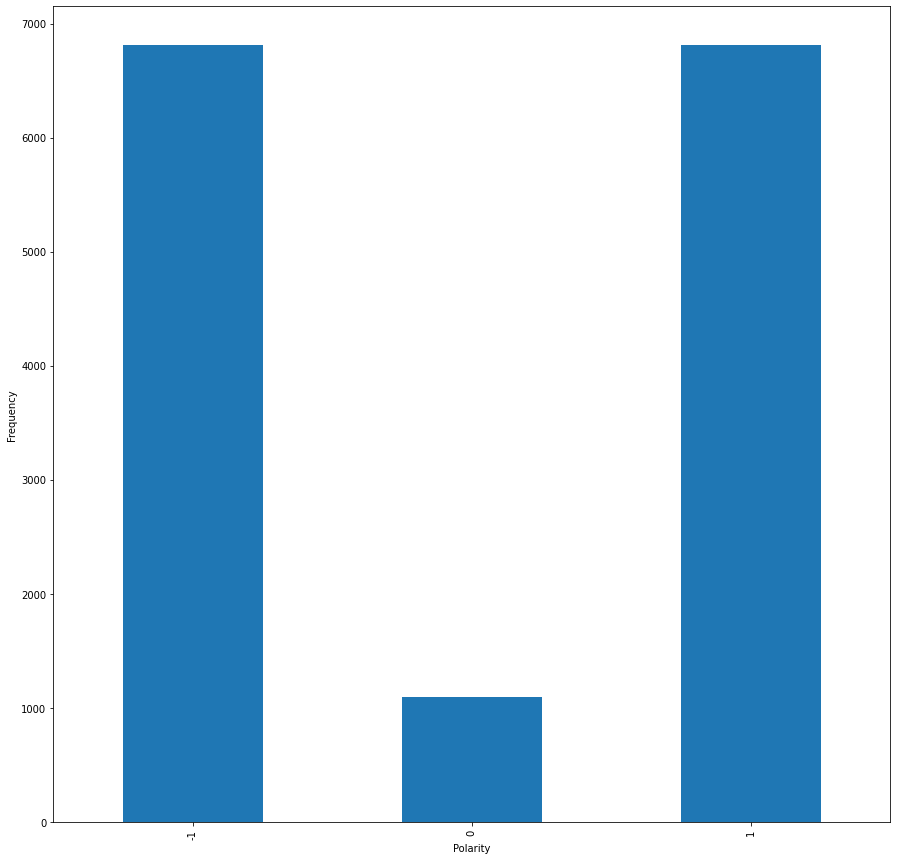

In [10]:
balanced_df['polarity'].value_counts(sort=False).plot.bar(figsize=(15,15))
plt.xlabel('Polarity')
plt.ylabel('Frequency')

#### Visualization

In [11]:
def get_wordcloud(text, color='viridis'):
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', colormap=color)
  # Generate a word cloud
  return wordcloud.generate(text)

(-0.5, 399.5, 199.5, -0.5)

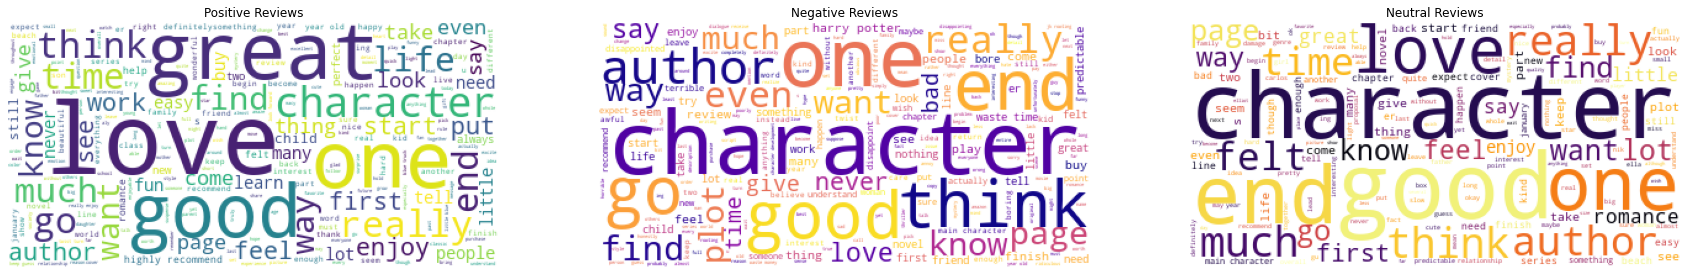

In [12]:
fig, axes =plt.subplots(1,3, figsize=(30,30))

# Wordcloud for positive reviews
pos_reviews = ' '.join(balanced_df['reviewDescription'][balanced_df['polarity']==1].values)
words = ['well', 'make', 'book', 'use', 'read', 'write','story']
for word in words:
  pos_reviews = pos_reviews.replace(word, '')

axes[0].set_title("Positive Reviews")
axes[0].imshow(get_wordcloud(pos_reviews))
axes[0].axis('off')


# Wordcloud for negative reviews
neg_reviews = ' '.join(balanced_df['reviewDescription'][balanced_df['polarity']==-1].values)

# Common words
words = ['well', 'make', 'book', 'use', 'read', 'write','story']
for word in words:
  neg_reviews = neg_reviews.replace(word, '')

axes[1].set_title("Negative Reviews")
axes[1].imshow(get_wordcloud(neg_reviews,'plasma'))
axes[1].axis('off')

# Wordcloud for neutral reviews
neutral_reviews = ' '.join(balanced_df['reviewDescription'][balanced_df['polarity']==0].values)
words = ['well', 'make', 'book', 'use', 'read', 'write','story']
for word in words:
  neutral_reviews = neutral_reviews.replace(word, '')

axes[2].set_title("Neutral Reviews")
axes[2].imshow(get_wordcloud(neutral_reviews, 'inferno'))
axes[2].axis('off')



## Modelling

In [13]:
X = balanced_df["reviewDescription"].values
Y = balanced_df["polarity"].values

### Train Test split 

### I redid the train test split using seed = 42

### After starting on the project I realised our steps should be

#### 1. Crawl the dataset ( crawl a shit ton maybe 100k? )
#### 2. Do data processing (Remove duplicates/Null/Non-english etc) 
#### 3. Use ratings to determine polarity and balance the dataset (Positive count == Negative count)
#### 4. Split the dataset (Train = 80% and Test = 20%)  I think there is a method to determine the best split but I am no expert lols
#### 5. Re annotate for test dataset(i can fake the annotations so this is pretty chill) + Inter annotator agreement
#### 5.5. OR we can crawl additional test dataset(unseen), do our data processing + self annotations + Inter annotator agreement
#### 6. Train model + evaluation(with #4 test set and #5.5 unseen test dataset)


In [14]:
# Train and test split 
# 70 train 30 test split
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#### Different methods of vectorizing text

**Bag-of-words Tf-Idf**

In [15]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer=word_tokenize)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
x_test_tfidf = tfidf_vect.transform(x_test)

Word2Vec - Averaged vector

Link: https://rare-technologies.com/word2vec-tutorial/

## TBH i don't fully understand this, I am following a tutorial for now on this

In [16]:
# Tokenization
X_train_tok = [word_tokenize(sentence) for sentence in X_train]
x_test_tok = [word_tokenize(sentence) for sentence in x_test]

In [17]:
# Word2Vec model
model_word2vec = Word2Vec(min_count=10,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [18]:
# Building vocabulary
model_word2vec.build_vocab(X_train_tok)

In [19]:
# Training model
model_word2vec.train(X_train_tok, total_examples=model_word2vec.corpus_count, epochs=30, report_delay=1)
model_word2vec.save("model/word2vec.model")

In [20]:
model_word2vec = gensim.models.word2vec.Word2Vec.load("model/word2vec.model")

In [21]:
# Compute mean vector given the word2vec vector for every word in a document
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) >= 1:
        return model.wv.get_mean_vector(words)
    else:
        return np.zeros(300)

In [22]:
# Get the mean vector
X_train_Word2Vec = [get_mean_vector(model_word2vec, review) for review in X_train_tok]
x_test_Word2Vec = [get_mean_vector(model_word2vec, review) for review in x_test_tok]

In [23]:
# Scaling values between 0 and 1
# Gotta investigate if it affects -1(negative) but MultinomialNB dont accept neg values so abit su
scaler_Word2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Word2Vec = scaler_Word2Vec.fit_transform(X_train_Word2Vec)
x_test_Word2Vec = scaler_Word2Vec.transform(x_test_Word2Vec)

## Doc2Vec

In [24]:
# Tag all the documents
tagged_data = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(X_train_tok)]

In [25]:
# Building of the Doc2Vec model
model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, epochs=10)
model_doc2vec.build_vocab(tagged_data)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [26]:
model_doc2vec.save("model/doc2vec.model")


In [27]:
model_doc2vec = gensim.models.doc2vec.Doc2Vec.load("model/doc2vec.model")

In [28]:
# Get the vectors for every document
X_train_Doc2Vec = model_doc2vec.dv.vectors
x_test_Doc2Vec = [model_doc2vec.infer_vector(doc) for doc in x_test_tok]

In [29]:
# Scaling values between 0 and 1

# Gotta investigate if it affects -1(negative) but MultinomialNB dont accept neg values so abit sus
scaler_Doc2Vec = MinMaxScaler(feature_range=(0,1))
X_train_Doc2Vec = scaler_Doc2Vec.fit_transform(X_train_Doc2Vec)
x_test_Doc2Vec = scaler_Doc2Vec.transform(x_test_Doc2Vec)

## Testing different models

## Bag-of-words Tf-Idf

#### Naive Bayes

In [30]:

# Naive bayes
naive_bayes_BOW = MultinomialNB()
naive_bayes_BOW.fit(X_train_tfidf, Y_train)

MultinomialNB()

In [31]:
naive_bayes_BOW_prediction = naive_bayes_BOW.predict(x_test_tfidf)

print(classification_report(y_test, naive_bayes_BOW_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.86431   0.93999   0.90057      2033
           0    0.00000   0.00000   0.00000       339
           1    0.86518   0.93340   0.89800      2042

    accuracy                        0.86475      4414
   macro avg    0.57650   0.62446   0.59952      4414
weighted avg    0.79834   0.86475   0.83021      4414



c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [32]:
from sklearn import metrics
print("MultinomialNB Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, naive_bayes_BOW_prediction))
naive_bayes_BOW_score = metrics.accuracy_score(y_test, naive_bayes_BOW_prediction)

MultinomialNB Accuracy for Bag of words TF-IDF: 0.8647485274127775


#### Linear SVC

In [33]:
# Support vector machine
Linear_SVC_BOW = LinearSVC(max_iter=3000)
Linear_SVC_BOW.fit(X_train_tfidf, Y_train)

LinearSVC(max_iter=3000)

In [34]:
Linear_SVC_BOW_prediction = Linear_SVC_BOW.predict(x_test_tfidf)
print(classification_report(y_test, Linear_SVC_BOW_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.87941   0.93261   0.90523      2033
           0    0.47967   0.17404   0.25541       339
           1    0.87728   0.91724   0.89682      2042

    accuracy                        0.86724      4414
   macro avg    0.74545   0.67463   0.68582      4414
weighted avg    0.84772   0.86724   0.85143      4414



In [35]:
print("Linear SVC Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, Linear_SVC_BOW_prediction))
Linear_SVC_BOW_score = metrics.accuracy_score(y_test, Linear_SVC_BOW_prediction)

Linear SVC Accuracy for Bag of words TF-IDF: 0.8672405980969642


In [36]:
Linear_SVC_pred_actual_dict = {"Prediction": Linear_SVC_BOW_prediction, "Actual": y_test}
Linear_SVC_pred_actual_df = pd.DataFrame.from_dict(Linear_SVC_pred_actual_dict)
Linear_SVC_pred_actual_df[Linear_SVC_pred_actual_df["Actual"] == 0].head()

,Prediction,Actual
19,-1,0
35,-1,0
40,-1,0
59,1,0
61,0,0


#### Logistic Regression

In [37]:
# Logistic regression
Logistic_Regression_BOW = LogisticRegression(max_iter=3000)
Logistic_Regression_BOW.fit(X_train_tfidf, Y_train)

LogisticRegression(max_iter=3000)

In [38]:
Logistic_Regression_BOW_prediction = Logistic_Regression_BOW.predict(x_test_tfidf)
print(classification_report(y_test, Logistic_Regression_BOW_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.85875   0.93901   0.89709      2033
           0    0.65517   0.05605   0.10326       339
           1    0.87095   0.92214   0.89581      2042

    accuracy                        0.86339      4414
   macro avg    0.79496   0.63906   0.63205      4414
weighted avg    0.84876   0.86339   0.83553      4414



In [39]:
print("Logistic Regression Accuracy for Bag of words TF-IDF:",metrics.accuracy_score(y_test, Logistic_Regression_BOW_prediction))
Logistic_Regression_BOW_score = metrics.accuracy_score(y_test, Logistic_Regression_BOW_prediction)

Logistic Regression Accuracy for Bag of words TF-IDF: 0.8633892161304939


## Word2Vec - Averaged vector

#### Naive Bayes

In [40]:
naive_bayes_Word2Vec = MultinomialNB()
naive_bayes_Word2Vec.fit(X_train_Word2Vec, Y_train)

MultinomialNB()

In [41]:
naive_bayes_Word2Vec_prediction = naive_bayes_Word2Vec.predict(x_test_Word2Vec)
print(classification_report(y_test, naive_bayes_Word2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.77449   0.90212   0.83345      2033
           0    0.00000   0.00000   0.00000       339
           1    0.83089   0.83252   0.83170      2042

    accuracy                        0.80063      4414
   macro avg    0.53513   0.57821   0.55505      4414
weighted avg    0.74110   0.80063   0.76863      4414



c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [42]:
print("MultinomialNB Accuracy for Word2Vec:",metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction))
naive_bayes_Word2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Word2Vec_prediction)

MultinomialNB Accuracy for Word2Vec: 0.8006343452650657


#### Linear SVC

In [43]:
# Support vector machine
Linear_SVC_Word2Vec = LinearSVC(max_iter=5000)
Linear_SVC_Word2Vec.fit(X_train_Word2Vec, Y_train)

LinearSVC(max_iter=5000)

In [44]:
Linear_SVC_Word2Vec_prediction = Linear_SVC_Word2Vec.predict(x_test_Word2Vec)
print(classification_report(y_test, Linear_SVC_Word2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.83446   0.90753   0.86946      2033
           0    0.26667   0.01180   0.02260       339
           1    0.84232   0.90255   0.87139      2042

    accuracy                        0.83643      4414
   macro avg    0.64782   0.60729   0.58782      4414
weighted avg    0.79449   0.83643   0.80532      4414



In [45]:
print("Linear SVC Accuracy for Linear_SVC_Word2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction))
Linear_SVC_Word2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Word2Vec_prediction)

Linear SVC Accuracy for Linear_SVC_Word2Vec: 0.8364295423652016


#### Logistic Regression

In [46]:
# Logistic regression
Logistic_Regression_Word2Vec = LogisticRegression(max_iter=5000)
Logistic_Regression_Word2Vec.fit(X_train_Word2Vec, Y_train)

LogisticRegression(max_iter=5000)

In [47]:
Logistic_Regression_Word2Vec_prediction = Logistic_Regression_Word2Vec.predict(x_test_Word2Vec)
print(classification_report(y_test, Logistic_Regression_Word2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.83576   0.90359   0.86835      2033
           0    0.23214   0.03835   0.06582       339
           1    0.84815   0.89716   0.87197      2042

    accuracy                        0.83416      4414
   macro avg    0.63868   0.61303   0.60205      4414
weighted avg    0.79513   0.83416   0.80839      4414



In [48]:
print("Logistic Regression Accuracy for Logistic_Regression_Word2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction))
Logistic_Regression_Word2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Word2Vec_prediction)

Logistic Regression Accuracy for Logistic_Regression_Word2Vec: 0.8341640235613955


## Doc2Vec

#### Naive Bayes

In [49]:
naive_bayes_Doc2Vec = MultinomialNB()
naive_bayes_Doc2Vec.fit(X_train_Doc2Vec, Y_train)

MultinomialNB()

In [50]:
naive_bayes_Doc2Vec_prediction = naive_bayes_Doc2Vec.predict(x_test_Doc2Vec)
print(classification_report(y_test, naive_bayes_Doc2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.70185   0.65421   0.67719      2033
           0    0.00000   0.00000   0.00000       339
           1    0.63914   0.78844   0.70599      2042

    accuracy                        0.66606      4414
   macro avg    0.44700   0.48088   0.46106      4414
weighted avg    0.61894   0.66606   0.63850      4414



c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [51]:
print("MultinomialNB Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction))
naive_bayes_Doc2Vec_score = metrics.accuracy_score(y_test, naive_bayes_Doc2Vec_prediction)

MultinomialNB Accuracy for Doc2Vec: 0.666062528318985


#### Linear SVC

In [52]:
# Support vector machine
Linear_SVC_Doc2Vec = LinearSVC(max_iter=5000)
Linear_SVC_Doc2Vec.fit(X_train_Doc2Vec, Y_train)

LinearSVC(max_iter=5000)

In [53]:
Linear_SVC_Doc2Vec_prediction = Linear_SVC_Doc2Vec.predict(x_test_Doc2Vec)
print(classification_report(y_test, Linear_SVC_Doc2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.75677   0.82489   0.78936      2033
           0    0.34694   0.05015   0.08763       339
           1    0.76594   0.80607   0.78549      2042

    accuracy                        0.75668      4414
   macro avg    0.62322   0.56037   0.55416      4414
weighted avg    0.72954   0.75668   0.73368      4414



In [54]:
print("Linear_SVC Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction))
Linear_SVC_Doc2Vec_score = metrics.accuracy_score(y_test, Linear_SVC_Doc2Vec_prediction)

Linear_SVC Accuracy for Doc2Vec: 0.7566832804712279


#### Logistic Regression

In [55]:
Logistic_Regression_Doc2Vec= LogisticRegression(max_iter=5000)
Logistic_Regression_Doc2Vec.fit(X_train_Doc2Vec, Y_train)

LogisticRegression(max_iter=5000)

In [56]:
Logistic_Regression_Doc2Vec_prediction = Logistic_Regression_Doc2Vec.predict(x_test_Doc2Vec)
print(classification_report(y_test, Logistic_Regression_Doc2Vec_prediction, digits=5))

              precision    recall  f1-score   support

          -1    0.76585   0.83178   0.79745      2033
           0    0.33871   0.06195   0.10474       339
           1    0.77099   0.80950   0.78978      2042

    accuracy                        0.76235      4414
   macro avg    0.62518   0.56774   0.56399      4414
weighted avg    0.73542   0.76235   0.74070      4414



In [57]:
print("Logistic Regression Accuracy for Doc2Vec:",metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction))
Logistic_Regression_Doc2Vec_score = metrics.accuracy_score(y_test, Logistic_Regression_Doc2Vec_prediction)

Logistic Regression Accuracy for Doc2Vec: 0.762347077480743


## Comparing the models

<BarContainer object of 3 artists>

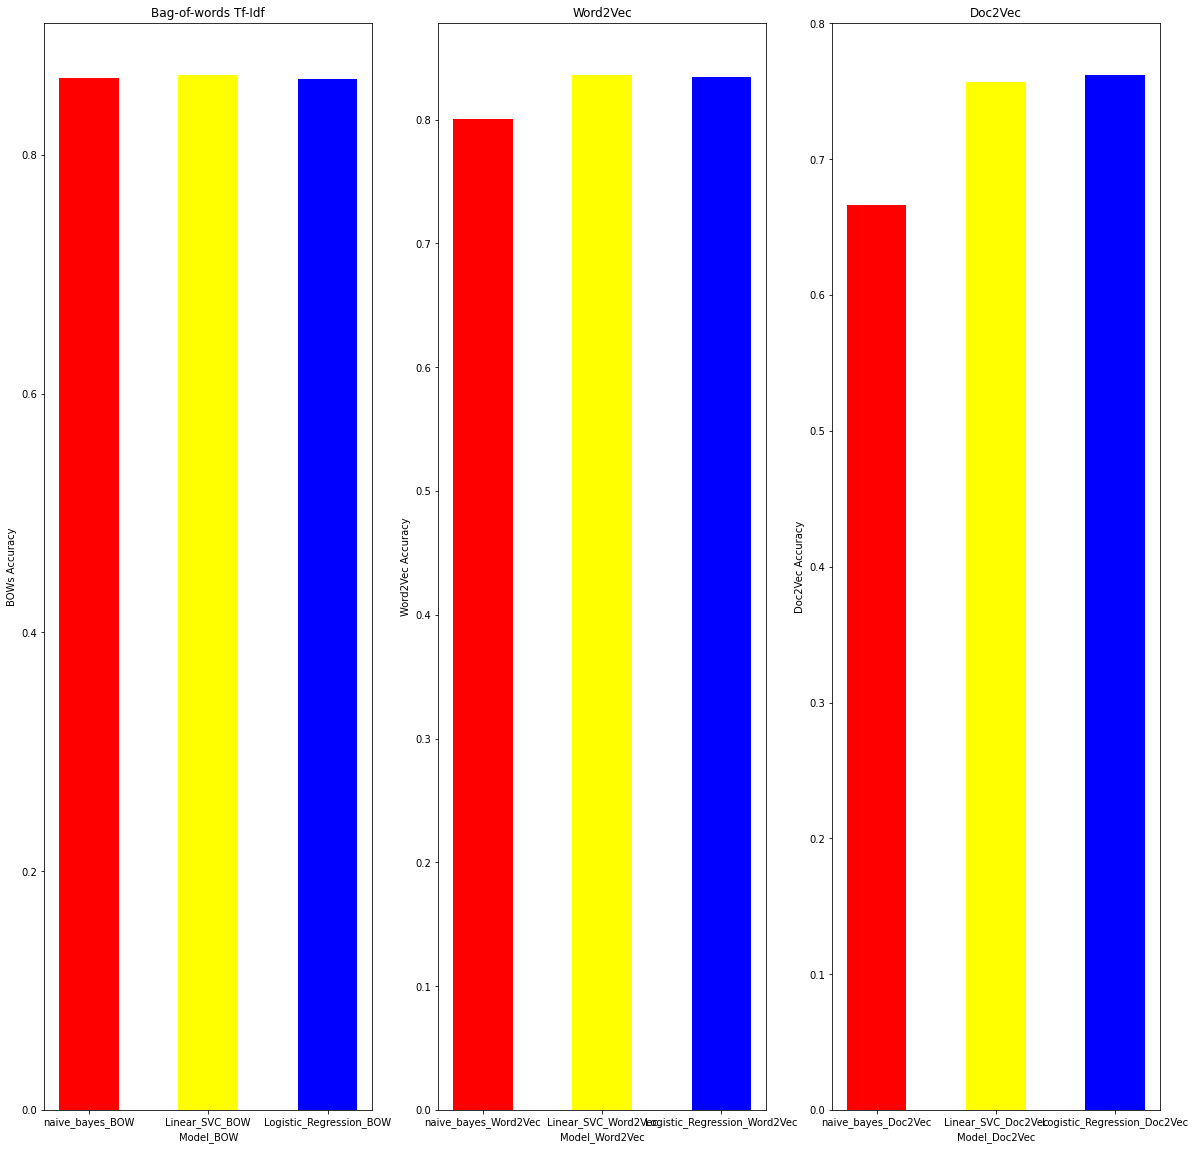

In [59]:
fig, axes =plt.subplots(1,3, figsize=(20,20))
# Bag of Words classifiers
classifiers = ["naive_bayes_BOW", "Linear_SVC_BOW", "Logistic_Regression_BOW"]

color_discrete_map=['red', 'yellow', 'blue']
accuracy = [naive_bayes_BOW_score, Linear_SVC_BOW_score, Logistic_Regression_BOW_score]
axes[0].set_title('Bag-of-words Tf-Idf')
axes[0].set_xlabel('Model_BOW')
axes[0].set_ylabel('BOWs Accuracy')
axes[0].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


# Word2Vec classifiers
classifiers = ["naive_bayes_Word2Vec", "Linear_SVC_Word2Vec", "Logistic_Regression_Word2Vec"]

color_discrete_map=['red', 'yellow', 'blue']
accuracy = [naive_bayes_Word2Vec_score, Linear_SVC_Word2Vec_score, Logistic_Regression_Word2Vec_score]
axes[1].set_title('Word2Vec')
axes[1].set_xlabel('Model_Word2Vec')
axes[1].set_ylabel('Word2Vec Accuracy')
axes[1].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)


# Doc2Vec classifiers
classifiers = ["naive_bayes_Doc2Vec", "Linear_SVC_Doc2Vec", "Logistic_Regression_Doc2Vec"]

color_discrete_map=['red', 'yellow', 'blue']
accuracy = [naive_bayes_Doc2Vec_score, Linear_SVC_Doc2Vec_score, Logistic_Regression_Doc2Vec_score]
axes[2].set_title('Doc2Vec')
axes[2].set_xlabel('Model_Doc2Vec')
axes[2].set_ylabel('Doc2Vec Accuracy')
axes[2].bar(classifiers, accuracy, color = color_discrete_map, width=0.5)
